In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from scipy.stats import pearsonr, spearmanr, kendalltau, fisher_exact, ttest_ind, sem, binom
from helpers import plot_params
from natsort import natsorted, natsort_keygen

In [2]:
%load_ext autoreload
%autoreload 2

## Load data

In [3]:
# Human data from Gerstenberg
intention = pd.read_csv('data/agents_intention.csv')
counterfactual = pd.read_csv('data/agents_counterfactual.csv')

In [4]:
# Model data we collected
subjects = ["FUYU", "OTTER", "ADAPTER", "GPT-4V", "CLAUDE-3"]
models = pd.read_csv("data/AGENTS_RESULTS.csv").loc[:, :subjects[-1]]
models.head()

,SEQ,COND,FUYU,OTTER,ADAPTER,GPT-4V,CLAUDE-3
0,1,Color,Blue,White,White,White,White
1,2,Color,Red,White,White,White,White
2,3,Color,Red,White,Blue,White,White
3,4,Color,Red,White,White,White,White
4,5,Color,Red,White,White,White,White


### 1. Analyze match to ground truth for color test

In [5]:
# Define subjects
colors = np.zeros(len(subjects))
colors_errs = np.zeros(len(subjects))
num_seqs = len(models[models.COND == "Color"])

# Loop through subjects
for ind, subject in enumerate(subjects):  

        # Absolute distance to ground truth and absolute distance to human average
        correct = sum(models[models.COND == "Color"][subject] == "White")
        colors[ind] = (correct / num_seqs)*100
        colors_errs[ind] = binom.std(num_seqs, correct / num_seqs)
        print(f"Color, {subject}: {colors[ind]:.4f} %")

Color, FUYU: 0.0000 %
Color, OTTER: 91.6667 %
Color, ADAPTER: 70.8333 %
Color, GPT-4V: 100.0000 %
Color, CLAUDE-3: 100.0000 %


### 2. Analyze visual understanding test: number of boxes in scene

In [6]:
# Define ground truth
numbers = np.zeros(len(subjects))
numbers_errs = np.zeros(len(subjects))
gt = [2, 3, 1, 1, 2, 1, 1, 2, 
      2, 1, 1, 2, 1, 1, 1, 1, 
      1, 1, 2, 2, 1, 1, 1, 1]
num_seqs = len(gt)

# Loop through subjects
for ind, subject in enumerate(subjects):  

        # Absolute distance to ground truth and absolute distance to human average
        correct = sum(np.equal(models[models.COND == "Number"][subject].values.astype(int), gt))
        numbers[ind] = (correct / num_seqs)*100
        numbers_errs[ind] = binom.std(num_seqs, correct / num_seqs)
        print(f"Number of boxes, {subject}: {numbers[ind]:.4f} %")

Number of boxes, FUYU: 16.6667 %
Number of boxes, OTTER: 16.6667 %
Number of boxes, ADAPTER: 29.1667 %
Number of boxes, GPT-4V: 66.6667 %
Number of boxes, CLAUDE-3: 62.5000 %


### 3. Regression to humans for intention

In [7]:
# Save human answers next to model answers for all models
# Output shape here is: (Number of humans * Number of test images, 3) 
# With 3 being: Model answers repeated number of humans times, All human answers, Human index
num_humans = len(intention.workerid.unique())
num_seqs = len(intention.trial.unique()) - 1 # -1 because nan is also counted
human_mean = intention.groupby('trial').mean('int')['int'].values

for model in (subjects + ["HUMAN"]):

    # Loop through all human subjects
    temp = np.zeros((num_humans*num_seqs, 3))
    temp[:] = np.nan
    for ind, human in enumerate(intention.workerid.unique()):

        # If array for human to human comparison, save human mean. Otherwise, save model answers in first column.
        if model == "HUMAN":
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = human_mean
        else:
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = models[models.COND == "Intention"][model].values.astype(float)

        # Save individual human answers and individual human id
        ind_human = intention[(intention.workerid == human) & (intention.trial.notna())].sort_values("trial", key=natsort_keygen())
        temp[(ind_human.trial.values.astype(int) - 1) + (ind*num_seqs), 1] = ind_human.int.values.astype(float)
        temp[ind*num_seqs:(ind+1)*num_seqs, 2] = human

    print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1], nan_policy="omit").statistic:.4f}")

    # Save to read in R after
    temp = pd.DataFrame(temp, columns=["Model", "Human", "Ind"])
    temp.to_csv(f"dataframes/05_agents/{model}_intention.csv")

FUYU, nan
OTTER, 0.2628
ADAPTER, 0.0000
GPT-4V, 0.0378
CLAUDE-3, -0.1311
HUMAN, 0.8493


#### Load linear mixed effects regression models from R

In [8]:
# Load
intention_lmer = pd.read_csv('dataframes/05_agents/05_intention_lmer.csv')

# Separate coefficient and re-format CI
intention_lmer_coef = intention_lmer.iloc[:,0].values
intention_lmer_conf = intention_lmer.iloc[:,1:].values.T

### 4. Counterfactual analysis

In [9]:
# Save human answers next to model answers for all models
# Output shape here is: (Number of humans * Number of test images, 3) 
# With 3 being: Model answers repeated number of humans times, All human answers, Human index
num_humans = len(counterfactual.workerid.unique())
num_seqs = len(counterfactual.trial.unique()) - 1 # -1 because nan is also counted
human_mean = counterfactual.groupby('trial').mean('cf')['cf'].values

for model in (subjects + ["HUMAN"]):

    # Loop through all human subjects
    temp = np.zeros((num_humans*num_seqs, 3))
    temp[:] = np.nan
    for ind, human in enumerate(counterfactual.workerid.unique()):

        # If array for human to human comparison, save human mean. Otherwise, save model answers in first column.
        if model == "HUMAN":
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = human_mean
        else:
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = models[models.COND == "Counterfactual"][model].values.astype(float)

        # Save individual human answers and individual human id
        ind_human = counterfactual[(counterfactual.workerid == human) & (counterfactual.trial.notna())].sort_values("trial", key=natsort_keygen())
        temp[(ind_human.trial.values.astype(int) - 1) + (ind*num_seqs), 1] = ind_human.cf.values.astype(float)
        temp[ind*num_seqs:(ind+1)*num_seqs, 2] = human

    print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1], nan_policy="omit").statistic:.4f}")

    # Save to read in R after
    temp = pd.DataFrame(temp, columns=["Model", "Human", "Ind"])
    temp.to_csv(f"dataframes/05_agents/{model}_counterfactual.csv")

FUYU, nan
OTTER, -0.3839
ADAPTER, nan
GPT-4V, 0.1269
CLAUDE-3, 0.1540
HUMAN, 0.7006


#### Load linear mixed effects regression models from R

In [10]:
# Load
counterfactual_lmer = pd.read_csv('dataframes/05_agents/05_counterfactual_lmer.csv')

# Separate coefficient and re-format CI
counterfactual_lmer_coef = counterfactual_lmer.iloc[:,0].values
counterfactual_lmer_conf = counterfactual_lmer.iloc[:,1:].values.T

## Make main plot


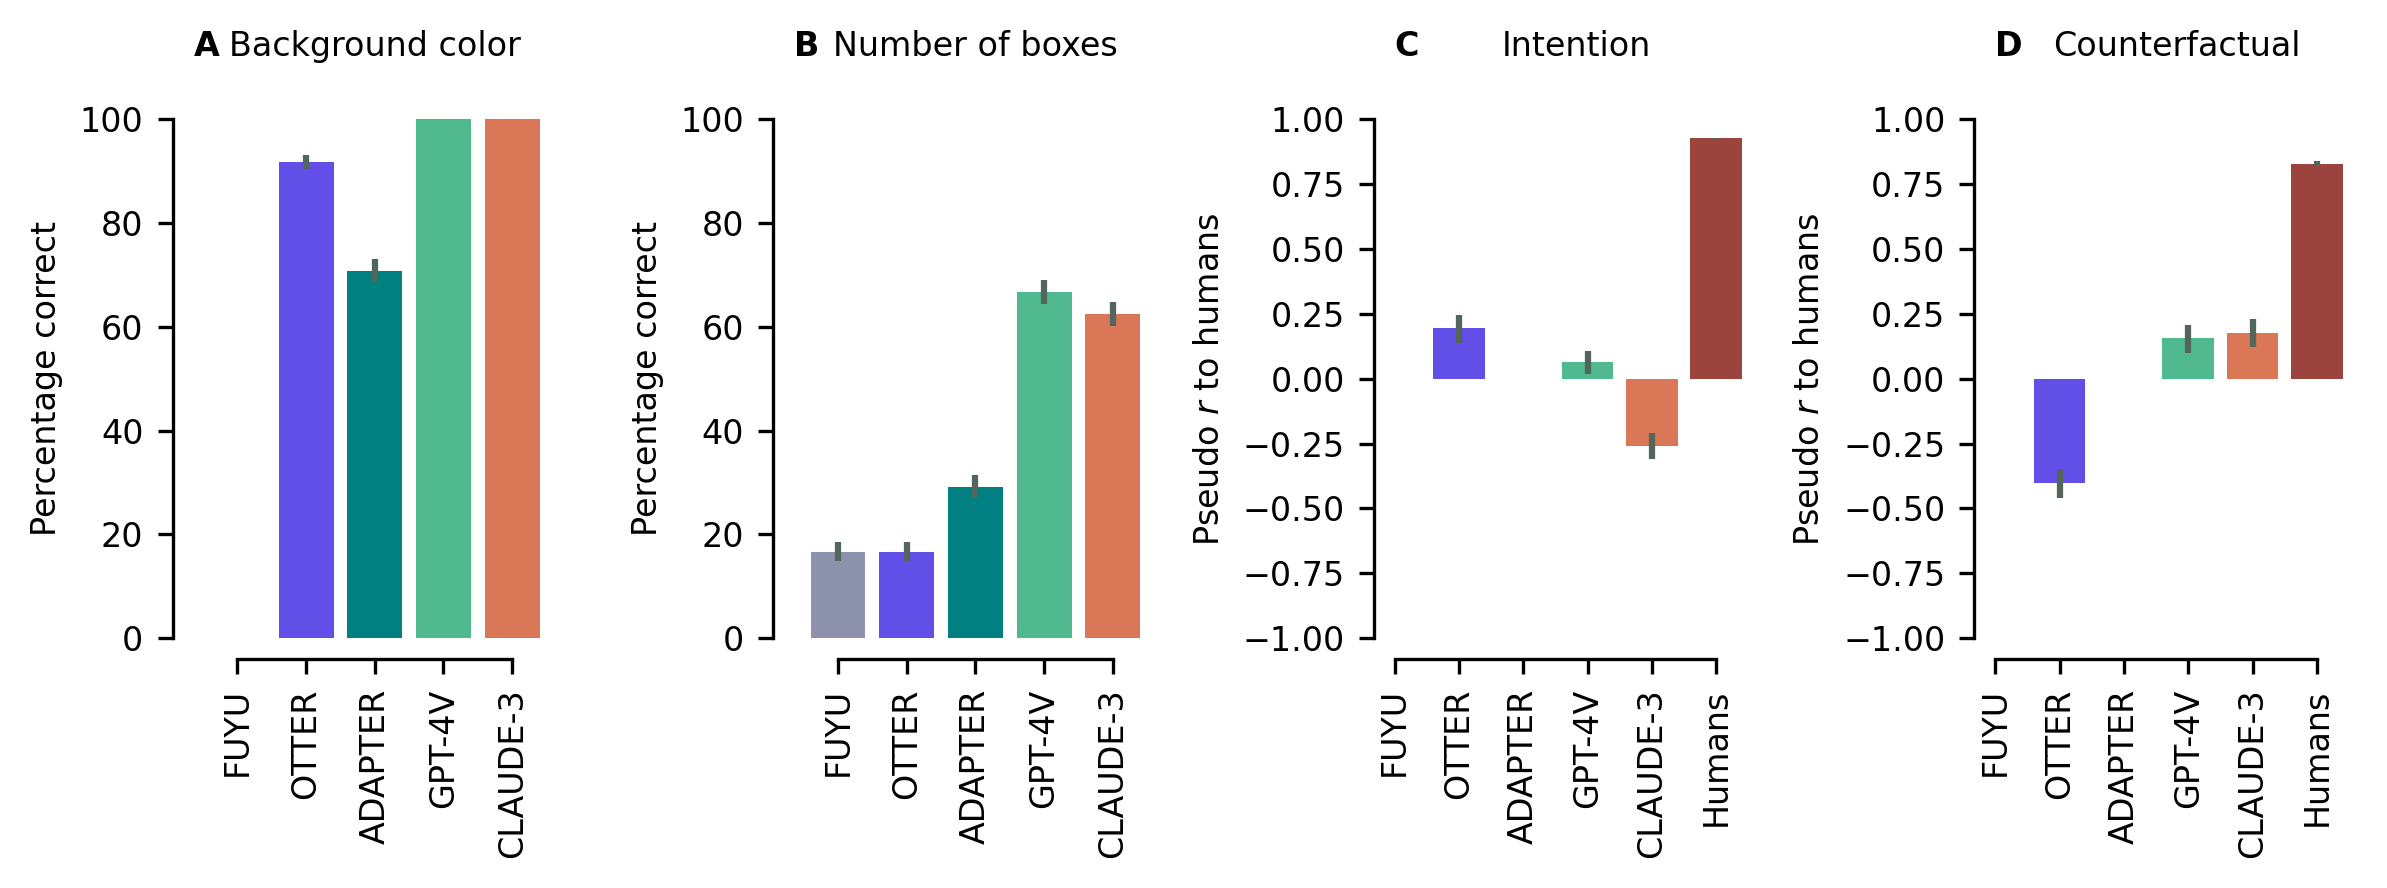

In [11]:
# Init plotting params
model_colors = plot_params()

# Prepare plot
num_subjects = len(subjects)
fig, axs = plt.subplots(1, 4, figsize=(8,3), sharey=False, tight_layout=True)  

# Plot A
axs[0].bar(np.arange(num_subjects), colors, color=model_colors)
axs[0].errorbar(np.arange(num_subjects), colors, yerr=colors_errs, ls="none")
axs[0].set_title("Background color\n")
axs[0].set_title("A\n", fontweight='bold', loc='left', fontsize='medium')
axs[0].set_ylabel("Percentage correct")
axs[0].set_ylim(0, 100)
#axs[0].axhline(y=random_dists[0])
axs[0].set_xticks(np.arange(num_subjects))

# Plot B
axs[1].bar(np.arange(num_subjects), numbers, color=model_colors)
axs[1].errorbar(np.arange(num_subjects), numbers, yerr=numbers_errs, ls="none")
axs[1].set_title("Number of boxes\n")
axs[1].set_title("B\n", fontweight='bold', loc='left', fontsize='medium')
axs[1].set_ylabel("Percentage correct")
axs[1].set_ylim(0, 100)
axs[1].set_xticks(np.arange(num_subjects))

# Plot C
axs[2].bar(np.arange(num_subjects+1), intention_lmer_coef, color=model_colors)
axs[2].errorbar(np.arange(num_subjects+1), intention_lmer_coef, yerr=intention_lmer_conf, ls="none")
axs[2].set_title("Intention\n", loc="center")
axs[2].set_title("C\n", fontweight='bold', loc='left', fontsize='medium')
axs[2].set_ylabel(f"Pseudo $r$ to humans")
axs[2].set_ylim(-1, 1)
axs[2].set_xticks(np.arange(num_subjects+1))

# Plot D
axs[3].bar(np.arange(num_subjects+1), counterfactual_lmer_coef, color=model_colors)
axs[3].errorbar(np.arange(num_subjects+1), counterfactual_lmer_coef, yerr=counterfactual_lmer_conf, ls="none")
axs[3].set_title("Counterfactual\n", loc="center")
axs[3].set_title("D\n", fontweight='bold', loc='left', fontsize='medium')
axs[3].set_ylabel(f"Pseudo $r$ to humans")
axs[3].set_ylim(-1, 1)
axs[3].set_xticks(np.arange(num_subjects+1))

# Despine and set x tick labels afterwards
sns.despine(offset=5, trim=True)
axs[0].set_xticklabels(subjects, rotation=90)
axs[1].set_xticklabels(subjects, rotation=90)
axs[2].set_xticklabels(subjects + ["Humans"], rotation=90)
axs[3].set_xticklabels(subjects + ["Humans"], rotation=90)
plt.savefig("figures/05_agents_main.pdf", dpi=300)

#### Additional: example plot for intention condition

In [20]:
np.sort(gpt4v), np.sort(human_mean)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., 50., 50., 50., 50., 50., 50.,
        50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.]),
 array([ 2.45833333,  3.        ,  3.14583333,  5.04081633,  6.85416667,
         6.93478261,  7.28      ,  7.47826087, 16.6875    , 27.82      ,
        35.15217391, 38.46938776, 65.375     , 71.95918367, 82.53191489,
        86.52083333, 92.65957447, 94.21276596, 95.83333333, 95.87755102,
        96.08333333, 96.79166667, 97.27083333, 97.67346939]))

In [17]:
human_mean = intention.groupby('trial').mean('int')['int'].values
gpt4v = models[models.COND == "Intention"]["GPT-4V"].values.astype(float)

# Sort ratings from low high (kind of like a confidence rating)
human_lowhigh = np.argsort(human_mean)
gpt4v_lowhigh = np.argsort(gpt4v)
print(human_lowhigh+1)
print(gpt4v_lowhigh+1)

[ 6 15  1  2  5 14  7  4 23 13  3 12 16 24 11 10 21  8 22 18 19  9 17 20]
[ 2  7 11 12 13 19 21  4  8  6  5 10  9 14  3  1 16 15 18 17 20 22 23 24]


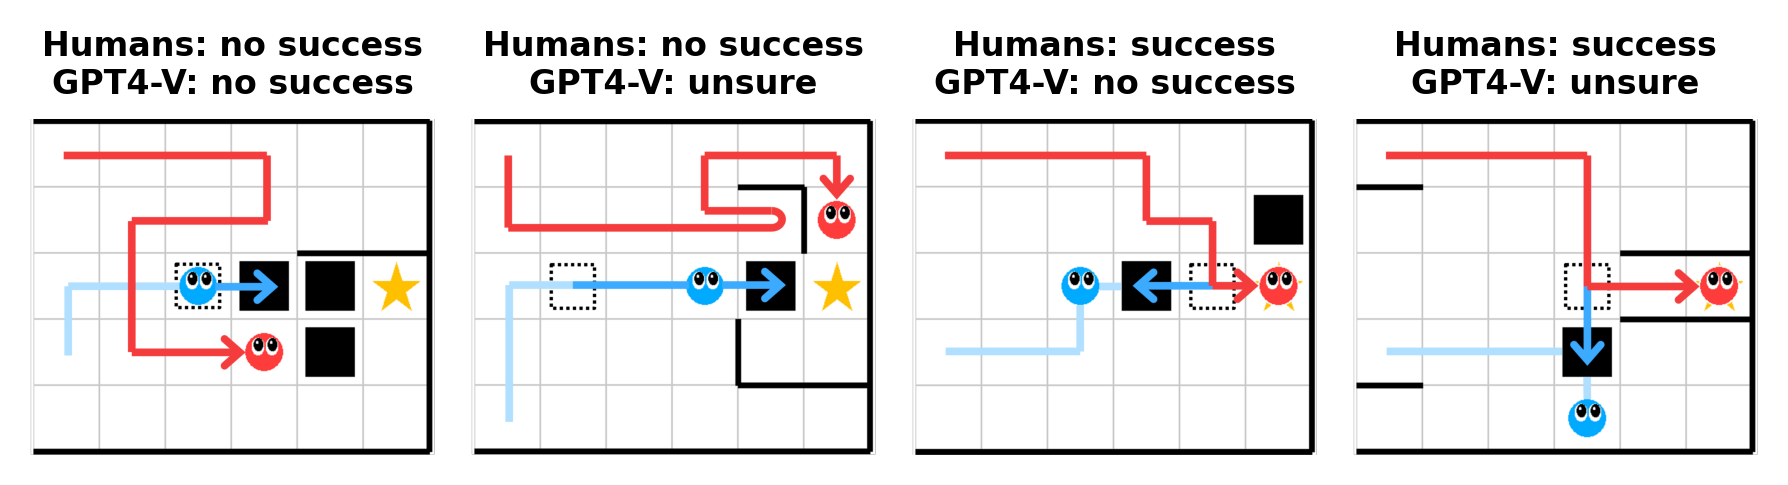

In [21]:
# Prepare plot
fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=True, figsize=(6,4))  

# First column: Humans: no success, GPT4V: no success (2)
axs[0].imshow(plt.imread("eval/images/agents/2.png"))
axs[0].axis("off")

# Second column: Humans: no success, GPT4V: unsure (15)
axs[1].imshow(plt.imread("eval/images/agents/15.png"))
axs[1].axis("off")

# Third column: Humans: success, GPT4V: no success (19)
axs[2].imshow(plt.imread("eval/images/agents/19.png"))
axs[2].axis("off")

# Fourth column: Humans: success, GPT4V: unsure (17)
axs[3].imshow(plt.imread("eval/images/agents/17.png"))
axs[3].axis("off")

# Set column titles
axs[0].set_title("Humans: no success\nGPT4-V: no success", fontweight="bold")
axs[1].set_title("Humans: no success\nGPT4-V: unsure", fontweight="bold")
axs[2].set_title("Humans: success\nGPT4-V: no success", fontweight="bold")
axs[3].set_title("Humans: success\nGPT4-V: unsure", fontweight="bold")
plt.savefig("figures/05_agents_examples.pdf", dpi=300, bbox_inches='tight')